In [1]:
import numpy as np
import csv, os
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd

TRAIN_PATH = "../data/train.csv"
VALID_PATH = "../data/test.csv"

In [2]:
# gradient decent
def GD(X, Y, ω, η, Iteration, λ): 
    """
    使用gradient decent learning rate 要調很小，不然很容易爆炸
    """
    listCost = []
    for itera in range(Iteration):
        arrayYHat = X.dot(ω)
        arrayLoss = arrayYHat - Y
        arrayCost = np.sqrt(np.mean(arrayLoss**2))
        listCost.append(arrayCost)

        arrayGradient = (X.T.dot(arrayLoss) / X.shape[0]) + (λ * ω)
        ω -= η * arrayGradient
        if itera % 1000 == 0:
            print("iteration:{}, cost:{} ".format(itera, arrayCost))
    return ω, listCost

In [3]:
# Adagrad
def Adagrad(X, Y, ω, η, Iteration, λ):
    listCost = []
    arrayGradientSum = np.zeros((X.shape[1],1))
    for itera in range(Iteration):
        arrayYHat = np.dot(X, ω)
        arrayLoss = arrayYHat - Y
        arrayCost = np.sqrt(np.mean(arrayLoss**2))

        # save cost function value in process
        listCost.append(arrayCost)

        arrayGradient = (np.dot(np.transpose(X), arrayLoss) / X.shape[0]) + (λ * ω)
        arrayGradientSum += arrayGradient**2
        arraySigma = np.sqrt(arrayGradientSum)
        ω -= η * arrayGradient / arraySigma

        if itera % 1000 == 0:
            print("iteration:{}, cost:{} ".format(itera, arrayCost))
    return ω, listCost

In [4]:
###---DataProcessing---###
# 讀進訓練資料
data = pd.read_csv(TRAIN_PATH, encoding='big5')  ## Read data
data.drop(columns=data.columns[:3], inplace=True) ## Remove first three columns
data.replace('NR', 0, inplace=True)             ## Replace NR to 0
data = data.astype(np.float)
data = data.to_numpy()
data[data<0] = 0

# 切分訓練資料
month_data = {}
for month in range(12):
    sample = np.empty([18, 480]) 
    # 將資料排程 Row -> 特徵, Col -> 時間
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample
    
listTrainX = np.empty([12 * 471, 18 * 9], dtype = float)
listTrainY = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            # 每個月只有 20 天的訓練資料，後面幾個小時無法使用
            if day == 19 and hour > 14:
                continue
            listTrainX[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            listTrainY[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value

# 正規化訓練資料
mean_x = np.mean(listTrainX, axis=0) #18 * 9 
std_x = np.std(listTrainX, axis=0) #18 * 9 
max_x = np.max(listTrainX, axis=0)
min_x = np.min(listTrainX, axis=0)

for i in range(len(listTrainX)): #12 * 471
    for j in range(len(listTrainX[0])): #18 * 9 
        if std_x[j] != 0:
#             listTrainX[i][j] = (listTrainX[i][j] - mean_x[j]) / std_x[j]
            listTrainX[i][j] = (listTrainX[i][j] - min_x[j]) / (max_x[j] - min_x[j])

    
# 讀進測試資料
data = pd.read_csv(VALID_PATH, header = None, encoding = 'big5')
data = data.iloc[:, 2:]
data[data == 'NR'] = 0
data = data.astype(np.float)
data = data.to_numpy()

listTestX = np.empty([240, 18*9], dtype = float)
for i in range(240):
    listTestX[i, :] = data[18 * i: 18* (i + 1), :].reshape(1, -1)
    
listTestX[listTestX < 0] = 0

    
for i in range(len(listTestX)):
    for j in range(len(listTestX[0])):
        if std_x[j] != 0:
#             listTestX[i][j] = (listTestX[i][j] - mean_x[j]) / std_x[j]
            listTestX[i][j] = (listTestX[i][j] - min_x[j]) / (max_x[j] - min_x[j])
            
arrayTestX = np.array(listTestX)
arrayTrainX = np.array(listTrainX)
arrayTrainY = np.array(listTrainY)

# 增加bias項
arrayTrainX = np.insert(arrayTrainX, arrayTrainX.shape[1], values=1, axis=1) # (5652, 163)
arrayTestX = np.insert(arrayTestX, arrayTestX.shape[1], values=1, axis=1) # (5652, 163)

In [20]:
###---Train---###
# gradient decent
intLearningRate = 5e-2
arrayW = np.zeros((arrayTrainX.shape[1],1))  # (163, )
arrayW_gd, listCost_gd = GD(X=arrayTrainX, Y=arrayTrainY, ω=arrayW, η=intLearningRate, Iteration=20000, λ=0)
arrayW = np.zeros((arrayTrainX.shape[1],1))  # (163, )
arrayW_gd_1, listCost_gd_1 = GD(X=arrayTrainX, Y=arrayTrainY, ω=arrayW, η=intLearningRate, Iteration=20000, λ=5e-4)
# Adagrad
intLearningRate = 1.27
arrayW = np.zeros((arrayTrainX.shape[1],1))  # (163, )
arrayW_ada, listCost_ada = Adagrad(X=arrayTrainX, Y=arrayTrainY, ω=arrayW, η=intLearningRate, Iteration=20000, λ=0)
# close form
arrayW_cf = inv(arrayTrainX.T.dot(arrayTrainX)).dot(arrayTrainX.T.dot(arrayTrainY))

iteration:0, cost:27.071044901246307 
iteration:1000, cost:7.768407065638882 
iteration:2000, cost:7.12143266407474 
iteration:3000, cost:6.790724838965352 
iteration:4000, cost:6.583905319714511 
iteration:5000, cost:6.440313917209712 
iteration:6000, cost:6.334007133140487 
iteration:7000, cost:6.251812969892971 
iteration:8000, cost:6.186220175348919 
iteration:9000, cost:6.132587265745939 
iteration:10000, cost:6.087875299287526 
iteration:11000, cost:6.05000514559957 
iteration:12000, cost:6.017503591133463 
iteration:13000, cost:5.989296135243041 
iteration:14000, cost:5.964579757508761 
iteration:15000, cost:5.94274171527777 
iteration:16000, cost:5.92330600161179 
iteration:17000, cost:5.905897028916367 
iteration:18000, cost:5.890214374775135 
iteration:19000, cost:5.876014827502526 
iteration:0, cost:27.071044901246307 
iteration:1000, cost:7.784498273728604 
iteration:2000, cost:7.150324139194332 
iteration:3000, cost:6.829826809463112 
iteration:4000, cost:6.63126698155544 

In [21]:
###---Test---###
# gradient decent
arrayPredictY_gd = np.dot(arrayTestX, arrayW_gd)
# Adagrad
arrayPredictY_ada = np.dot(arrayTestX, arrayW_ada)
# close form
arrayPredictY_cf = np.dot(arrayTestX, arrayW_cf)

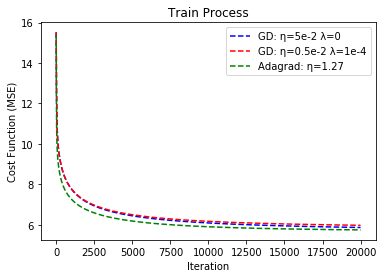

In [22]:
###---Visualization---###
plt.plot(np.arange(len(listCost_gd[3:])), listCost_gd[3:], "b--", label="GD: η=5e-2 λ=0")
plt.plot(np.arange(len(listCost_gd_1[3:])), listCost_gd_1[3:], "r--", label="GD: η=0.5e-2 λ=1e-4")
plt.plot(np.arange(len(listCost_ada[3:])), listCost_ada[3:], "g--", label="Adagrad: η=1.27")
plt.title("Train Process")
plt.xlabel("Iteration")
plt.ylabel("Cost Function (MSE)")
plt.legend()
plt.savefig("../Output/TrainProcess")
plt.show()


In [23]:
# compare predict value with different methods
dcitD = {"Adagrad":[arrayPredictY_ada], "CloseForm":[arrayPredictY_cf], "GD":[arrayPredictY_gd]}
pdResult = pd.DataFrame(dcitD)
print(pdResult["Adagrad"])

0    [[5.12418331848644], [16.99517280017774], [23....
Name: Adagrad, dtype: object


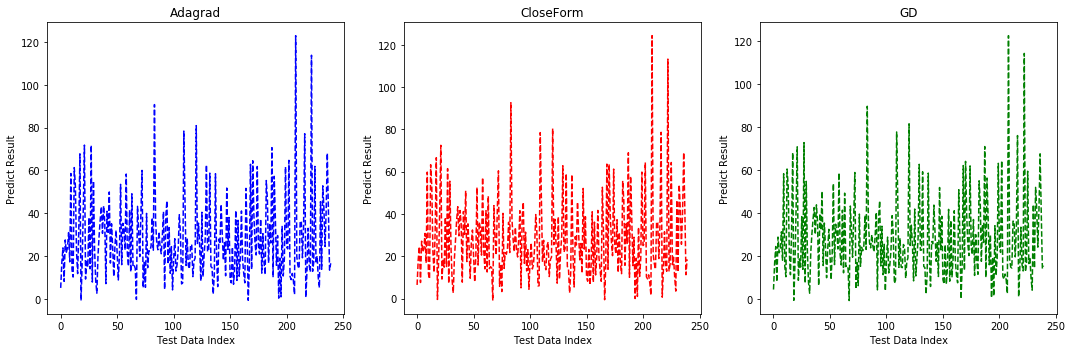

In [24]:
# visualize predict value with different methods
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(np.arange(len(arrayPredictY_ada)), arrayPredictY_ada, "b--")
plt.title("Adagrad")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")

plt.subplot(132)
plt.plot(np.arange(len(arrayPredictY_cf)), arrayPredictY_cf, "r--")
plt.title("CloseForm")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")

plt.subplot(133)
plt.plot(np.arange(len(arrayPredictY_gd)), arrayPredictY_gd, "g--")
plt.title("GD")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")

plt.tight_layout()
plt.savefig("../Output/Compare.png")
plt.show()